In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [8]:
# Load CSV File
df = pd.read_csv('Bitcoin Historical Data.csv')
df1 = df.reset_index()['Price']

In [9]:
print(df)
df.describe()

           Date    Price     Open     High      Low    Vol.  Change
0      3/1/2013     34.5     33.4     34.9     32.9   39790    0.03
1      3/2/2013     34.3     34.5     34.8     33.2   36660   -0.01
2      3/3/2013     34.5     34.3     34.5     33.8   12530    0.01
3      3/4/2013     36.2     34.5     36.7     34.2   46770    0.05
4      3/5/2013     40.3     36.2     40.7     36.2   85430    0.12
...         ...      ...      ...      ...      ...     ...     ...
4014  2/26/2024  54495.1  51722.7  54899.1  50925.2   78050    0.05
4015  2/27/2024  57056.2  54491.1  57555.2  54464.0  100480    0.05
4016  2/28/2024  62467.6  57048.7  63915.3  56704.9  173640    0.09
4017  2/29/2024  61169.3  62467.1  63653.4  60512.5  119290   -0.02
4018   3/1/2024  62397.7  61157.3  63147.3  60790.9   74960    0.02

[4019 rows x 7 columns]


,Price,Open,High,Low,Vol.,Change
count,4019.000000,4019.000000,4019.000000,4019.000000,4.019000e+03,4019.000000
mean,13062.803857,13047.379895,13370.161035,12702.595372,1.536602e+07,0.003546
std,16218.664558,16201.380862,16603.155376,15770.236972,1.726157e+08,0.072383
min,34.300000,33.400000,34.500000,32.900000,2.600000e+02,-0.570000
25%,564.500000,564.350000,575.300000,526.850000,4.102500e+04,-0.010000
50%,6636.000000,6633.900000,6780.500000,6502.000000,8.726000e+04,0.000000
75%,21062.350000,20996.850000,21521.350000,20542.200000,2.569350e+05,0.020000
max,67527.900000,67528.700000,68990.600000,66334.900000,4.470000e+09,3.370000


In [10]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [11]:
# Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [12]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
43/43 [==============================] - 2s 17ms/step - loss: 0.0045
Epoch 2/100
43/43 [==============================] - 1s 17ms/step - loss: 3.6942e-04
Epoch 3/100
43/43 [==============================] - 1s 16ms/step - loss: 2.5416e-04
Epoch 4/100
43/43 [==============================] - 1s 17ms/step - loss: 1.8998e-04
Epoch 5/100
43/43 [==============================] - 1s 17ms/step - loss: 1.4174e-04
Epoch 6/100
43/43 [==============================] - 1s 16ms/step - loss: 1.2393e-04
Epoch 7/100
43/43 [==============================] - 1s 17ms/step - loss: 9.3059e-05
Epoch 8/100
43/43 [==============================] - 1s 16ms/step - loss: 8.2100e-05
Epoch 9/100
43/43 [==============================] - 1s 17ms/step - loss: 7.1033e-05
Epoch 10/100
43/43 [==============================] - 1s 21ms/step - loss: 6.2162e-05
Epoch 11/100
43/43 [==============================] - 1s 34ms/step - loss: 5.8612e-05
Epoch 12/100
43/43 [==============================] - 2s 52ms/step 

In [16]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

35/35 [==============================] - 0s 7ms/step


In [17]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [18]:
# Forecast Next 30 Days
last_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

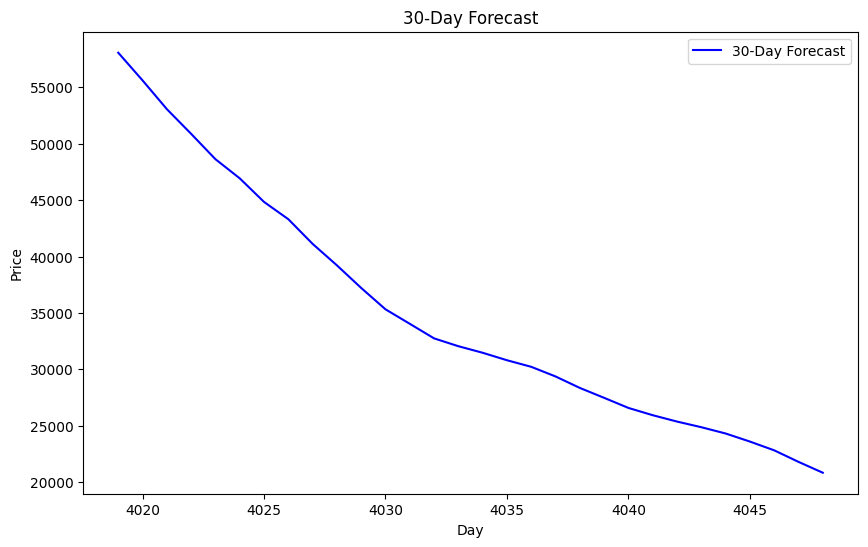

In [19]:
# Assuming 'lst_output' contains your 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)

# Plotting the 30-day forecast
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, color='blue')
plt.title('30-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['30-Day Forecast'])
plt.show()

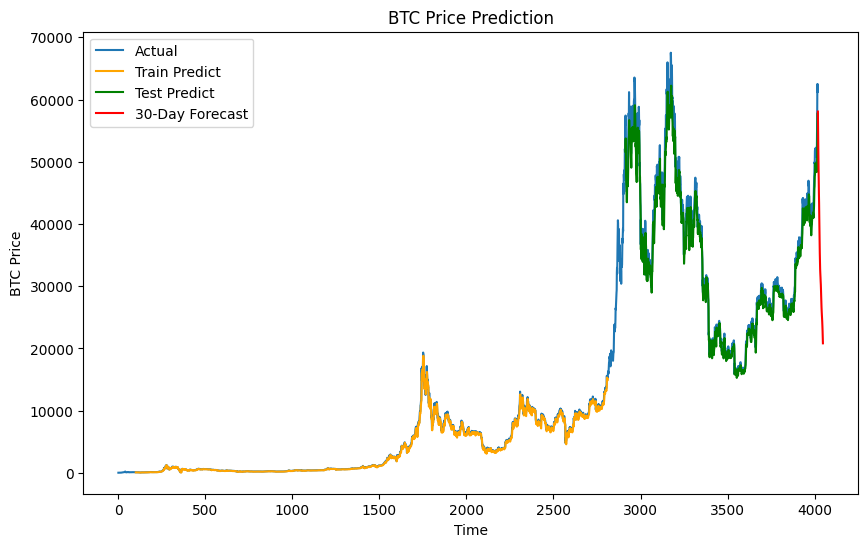

In [22]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))

# Plot entire dataset
plt.plot(scaler.inverse_transform(df1), label='Actual')

# Plot training predictions
train_predict_plot = np.empty_like(df1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Train Predict', color='orange')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Test Predict', color='green')

# Plot 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, label='30-Day Forecast', color='red')

# Adding legends and labels
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

# Compute Huber Loss
delta = 1.0  # You can adjust the delta parameter
test_huber_loss = np.mean(huber_loss(y_test_actual, test_predict, delta))
print('Testing Huber Loss:', test_huber_loss)

Testing RMSE: 2088.405276389095
Testing MAE: 1558.0196291713803
Testing MAPE: 4.078905530980673
Testing Huber Loss: 1557.5196291713803
